In [1]:
import import_ipynb
import functions as fn
import numpy as np
from lstmcontroller import LstmController
from pidcontroller import PidController
import matplotlib.pyplot as plt
import imageio
import tclab
from filelogger import FileLogger
from consolelogger import ConsoleLogger
from progresslogger import ProgressLogger

importing Jupyter notebook from functions.ipynb
importing Jupyter notebook from lstmcontroller.ipynb
importing Jupyter notebook from pidcontroller.ipynb
importing Jupyter notebook from filelogger.ipynb
importing Jupyter notebook from consolelogger.ipynb
importing Jupyter notebook from progresslogger.ipynb


d:\programs\python 3.9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
run_time = 30 * 60
Tsp = fn.generate_temperature_setpoints(30, 23.67, 240, 600, 30, 70, run_time + 1, seed=5)
kp = 6
ki = 0.08
kd = 0
out_min = 0
out_max = 100

TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.


In [3]:
loggers = [FileLogger('heater_anomaly.log'), ProgressLogger(r'\d+', run_time)]
controllers = [PidController(kp, ki, kd, out_min, out_max, window=15), LstmController.load_model('pid_emulate.h5', 'model_params.pkl')]
tm, T1, Q1, Qrest = fn.run_tclab(run_time, Tsp, controllers, loggers=loggers, connected=False, speedup=60, Q2=[0] * 900 + [80] * 901)

  0%|                                                                                 | 1/1800 [00:01<53:13,  1.78s/it]

TCLab version 0.4.9
Simulated TCLab


100%|██████████████████████████████████████████████████████████████████████████████| 1800/1800 [03:10<00:00,  9.46it/s]

Progress Logger: pbar closed
TCLab Model disconnected successfully.


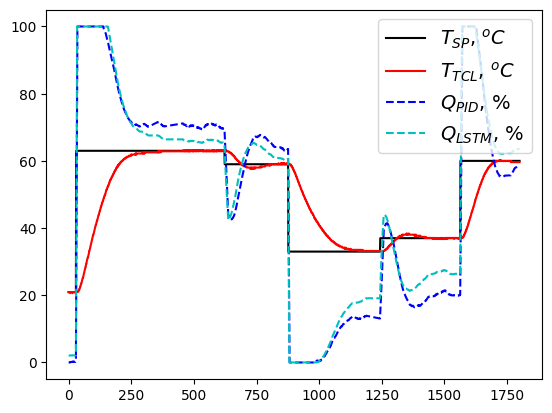

In [4]:
plt.plot(Tsp,'k-',label='$T_{SP}$, $^oC$')
plt.plot(T1, 'r-',label='$T_{TCL}$, $^oC$')
plt.plot(Q1,'b--',label='$Q_{PID}$, %')
plt.plot(Qrest[0],'c--',label='$Q_{LSTM}$, %')
plt.legend(loc='upper right',fontsize=14)
plt.savefig('heater_anomaly.png');

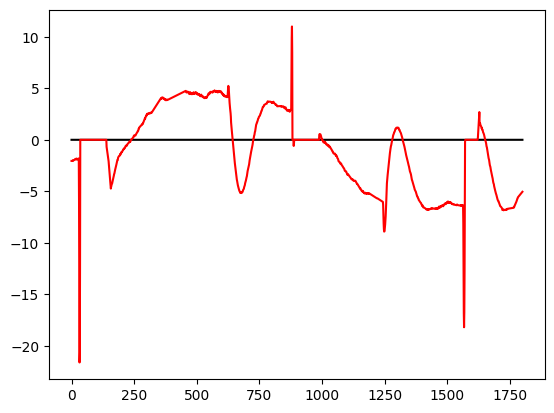

In [5]:
plt.plot([0] * (run_time + 1),'k-')
plt.plot(Q1 - Qrest[0],'r-',label='$dQ$, %')
plt.savefig('heater_anomaly_diff.png')

In [6]:
loggers = [FileLogger('pid_anomaly.log'), ProgressLogger(r'\d+', run_time)]
pid = PidController(kp, ki, kd, out_min, out_max, window=15)
lstm = LstmController.load_model('pid_emulate.h5', 'model_params.pkl')
anomaly_start = 20 * 60
tm, T1, Q1, Qrest = fn.run_tclab(anomaly_start, Tsp[:anomaly_start + 1], [pid, lstm], loggers=loggers, connected=False, speedup=60)
pid.kp = 1
pid.ki = 0.7
pid.kd = -1
tm_, T1_, Q1_, Qrest_ = fn.run_tclab(run_time - anomaly_start, Tsp[anomaly_start:], [pid, lstm], loggers=loggers, connected=False, speedup=60)

  0%|                                                                                 | 1/1800 [00:01<50:56,  1.70s/it]

TCLab version 0.4.9
Simulated TCLab


 67%|████████████████████████████████████████████████████                          | 1200/1800 [01:57<01:02,  9.67it/s]

TCLab Model disconnected successfully.
TCLab version 0.4.9
Simulated TCLab


 33%|██████████████████████████▎                                                    | 600/1800 [02:58<02:14,  8.95it/s]

TCLab Model disconnected successfully.


In [7]:
tm = list(tm) + list(tm_ + tm[-1])
T1 = list(T1) + list(T1_)
Q1 = list(Q1) + list(Q1_)
Qrest = [list(Qrest[i]) + list(Qrest_[i]) for i in range(len(Qrest))]

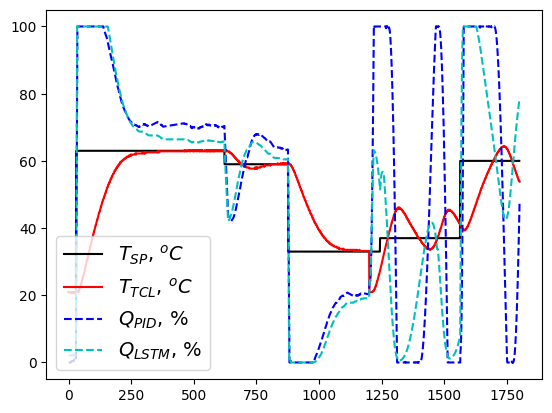

In [11]:
plt.plot(Tsp,'k-',label='$T_{SP}$, $^oC$')
plt.plot(T1, 'r-',label='$T_{TCL}$, $^oC$')
plt.plot(Q1,'b--',label='$Q_{PID}$, %')
plt.plot(Qrest[0],'c--',label='$Q_{LSTM}$, %')
plt.legend(loc='lower left',fontsize=14)
plt.savefig('pid_anomaly.png');

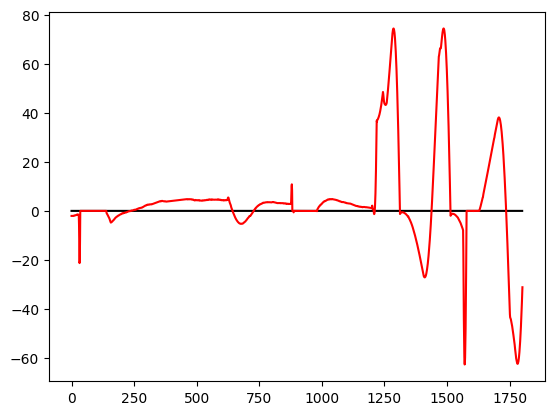

In [13]:
plt.plot([0] * (run_time + 1),'k-')
plt.plot(np.array(Q1) - np.array(Qrest[0]),'r-',label='$T_{SP}$, $^oC$')
plt.savefig('pid_anomaly_diff.png')